## Data Preprocessing

In [ ]:
import pandas as pd

#load in data
df = pd.read_excel("final_data.xlsx")
df.head()

#transform Willingness labels from strings to integers
df.Willingness[df.Willingness == 'No'] = 0
df.Willingness[df.Willingness == 'Not sure'] = 1
df.Willingness[df.Willingness == 'Yes'] = 2

#split into train, test files 
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)


print("Length of traning dataset: ", len(train))
print("Length of testing dataset: ", len(test))

train.head()


Length of traning dataset:  5166
Length of testing dataset:  1292


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


,text,Record,Vaccine Name,Attitude,Willingness
52,"Like the AstraZeneca, how many children are su...",4847,AstraZeneca,Negative,0
4401,i’m taking the vaccine out of my arm myself fu...,1886,Pfizer,Negative,2
5335,wait is the sinovac vaccine being widely used ...,8432,Sinovac,Positive,2
1029,With their umming and erring over what to do w...,6186,AstraZeneca,Neutral,1
3412,I got mine today!!! Right now I am waiting the...,710,Pfizer,Positive,2


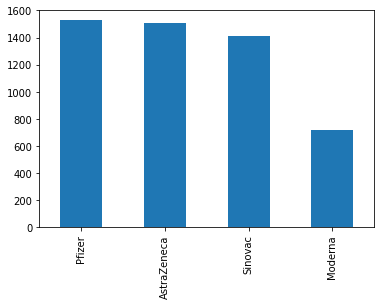

In [ ]:
train["Vaccine Name"].value_counts().plot(kind='bar')

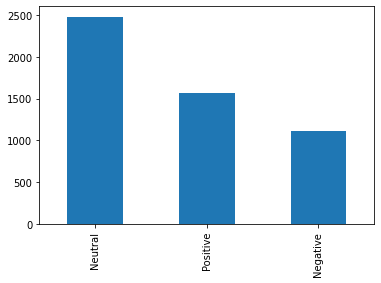

In [ ]:
train['Attitude'].value_counts().plot(kind='bar')

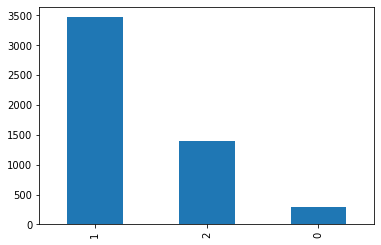

In [ ]:
train['Willingness'].value_counts().plot(kind='bar')

In [ ]:
import numpy as np

seq_len = 512
num_samples = len(df)

num_samples, seq_len

(6458, 512)

In [ ]:
!pip install transformers
from transformers import BertTokenizer

# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['text'].tolist(), max_length=seq_len, truncation=True,
                   padding='max_length', add_special_tokens=True,
                   return_tensors='np')

In [ ]:

tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
tokens['input_ids'][:10]

array([[  101,  1573,   117, ...,     0,     0,     0],
       [  101,  1109, 20034, ...,     0,     0,     0],
       [  101,  1109,  2233, ...,     0,     0,     0],
       ...,
       [  101,  1327,  1195, ...,     0,     0,     0],
       [  101, 11750,   117, ...,     0,     0,     0],
       [  101,  1247,  1110, ...,     0,     0,     0]])

In [ ]:
tokens['attention_mask'][:10]

array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])

In [ ]:
with open('willingness-xids.npy', 'wb') as f:
    np.save(f, tokens['input_ids'])
with open('willingness-xmask.npy', 'wb') as f:
    np.save(f, tokens['attention_mask'])

In [ ]:
_#extract vaccine name column
arr = df['Willingness'].values.astype(int)

In [ ]:
#we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(6458, 3)

In [ ]:
labels[np.arange(num_samples), arr] = 1

labels

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 1., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
with open('willingness-labels.npy', 'wb') as f:
    np.save(f, labels)

## Input Pipeline

In [ ]:
import numpy as np

with open('willingness-xids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('willingness-xmask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('willingness-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

In [ ]:

import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((Xids, Xmask, labels))

dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (3,)), types: (tf.int64, tf.int64, tf.float64)>

In [ ]:

def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (3,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [ ]:

batch_size = 8

dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (8, 512), attention_mask: (8, 512)}, (8, 3)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [ ]:
split = 0.9

# we need to calculate how many batches must be taken to create 90% training set
size = int((Xids.shape[0] / batch_size) * split)

size

726

In [ ]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size)

In [ ]:

tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [ ]:

train_ds.element_spec

({'attention_mask': TensorSpec(shape=(8, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(8, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(8, 3), dtype=tf.float64, name=None))

In [ ]:
val_ds.element_spec == train_ds.element_spec

True

In [ ]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

## Build and Train

In [ ]:

from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()


Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int64')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int64')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 3 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(3, activation='softmax', name='outputs')(x)

In [ ]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
#model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(8, 512), dtype=tf.int64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(8, 512), dtype=tf.int64, name=None)},
                tf.TensorSpec(shape=(8, 3), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('train', element_spec=element_spec)
val_ds = tf.data.experimental.load('val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (8, 512), attention_mask: (8, 512)}, (8, 3)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

In [ ]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=3
)

Epoch 1/3
726/726 [==============================] - 1310s 2s/step - loss: 0.6041 - accuracy: 0.7713 - val_loss: 0.5097 - val_accuracy: 0.8179
Epoch 2/3
726/726 [==============================] - 1300s 2s/step - loss: 0.4592 - accuracy: 0.8328 - val_loss: 0.3943 - val_accuracy: 0.8534
Epoch 3/3
726/726 [==============================] - 1294s 2s/step - loss: 0.3097 - accuracy: 0.8871 - val_loss: 0.2827 - val_accuracy: 0.9059


In [ ]:
model.save('Bert_Willingness_model-90%')


INFO:tensorflow:Assets written to: Bert_Willingness_model-90%/assets


INFO:tensorflow:Assets written to: Bert_Willingness_model-90%/assets
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


## Load and Predict

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('Bert_Willingness_model-90%')

# view model architecture to confirm we have save and loaded correctly
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

def prep_data(text):
    tokens = tokenizer.encode_plus(text, max_length=512,
                                   truncation=True, padding='max_length',
                                   add_special_tokens=True, return_token_type_ids=False,
                                   return_tensors='tf')
    # tokenizer returns int32 tensors, we need to return float64, so we use tf.cast
    return {'input_ids': tf.cast(tokens['input_ids'], tf.float64),
            'attention_mask': tf.cast(tokens['attention_mask'], tf.float64)}

In [ ]:
# 0 negative, 1 neutral, 2 positive
probs0 = model.predict(prep_data("I'm excited that I'm finally getting Pfizer"))[0]
probs1 = model.predict(prep_data("The side effects are so annoying"))[0]
probs2 = model.predict(prep_data("The government started distributing AstraZeneca vaccines."))[0]



print(np.argmax(probs0), np.argmax(probs1), np.argmax(probs2))

2 2 1


In [ ]:
#transforming first time run
!zip -r /content/Bert_Willingness_model-90%.zip /content/Bert_Willingness_model-90%

from google.colab import files
files.download("/content/Bert_Willingness_model-90%.zip")


updating: content/Bert_Willingness_model-90%/ (stored 0%)
updating: content/Bert_Willingness_model-90%/saved_model.pb (deflated 92%)
updating: content/Bert_Willingness_model-90%/assets/ (stored 0%)
updating: content/Bert_Willingness_model-90%/variables/ (stored 0%)
updating: content/Bert_Willingness_model-90%/variables/variables.index (deflated 80%)
updating: content/Bert_Willingness_model-90%/variables/variables.data-00000-of-00001 (deflated 16%)
updating: content/Bert_Willingness_model-90%/keras_metadata.pb (deflated 95%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>